In [1]:
%load_ext autoreload
%autoreload 2

# Disable tf hardware warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
from mmd_wrapper.utilities import *
import numpy as np
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


# MMD-MA

In [3]:
with open('./sample_data/mmd_ma/X_linearkernel.tsv', 'r') as f:
    k1_matrix = np.array([[float(num) for num in line.split('\t')] for line in f ])
with open('./sample_data/mmd_ma/Y_linearkernel.tsv', 'r') as f:
    k2_matrix = np.array([[float(num) for num in line.split('\t')] for line in f ])

In [4]:
mmd_ma_out = mmd_combine(k1_matrix, k2_matrix, method='mmd_ma')
mapping, hist, weights = mmd_ma_out

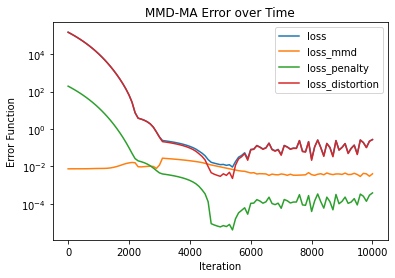

In [5]:
keys = ['loss', 'loss_mmd', 'loss_penalty', 'loss_distortion']
plot_training(hist, keys, alg_name='MMD-MA', log_plot=True)

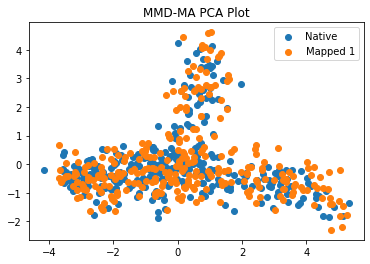

In [6]:
alignment_visualize(*mapping, alg_name='MMD-MA')

# UnionCom

In [7]:
data1 = np.loadtxt("./sample_data/unioncom/domain1.txt")
data2 = np.loadtxt("./sample_data/unioncom/domain2.txt")
type1 = np.loadtxt("./sample_data/unioncom/type1.txt")
type2 = np.loadtxt("./sample_data/unioncom/type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)

In [8]:
unioncom_out = mmd_combine(data1, data2, method='unioncom', 
                                verbose=0, 
                                updated=False)
mapping, hist, uc = unioncom_out
uc.test_LabelTA(mapping, [type1, type2])

label transfer accuracy of data1:
0.97


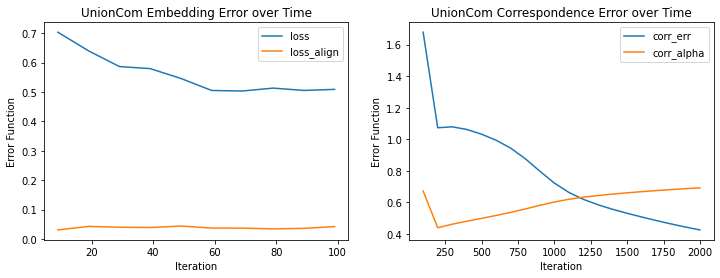

In [9]:
plt.subplots(figsize=(12,4))

plt.subplot(1,2,1)
keys = ['loss', 'loss_align']
plot_training(hist, keys, alg_name='UnionCom Embedding')

plt.subplot(1,2,2)
keys = ['corr_err', 'corr_alpha']
plot_training(hist, keys, alg_name='UnionCom Correspondence', iter_key='corr_iteration')

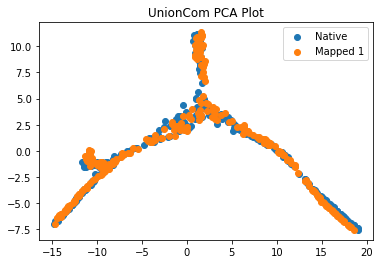

In [10]:
alignment_visualize(*mapping, alg_name='UnionCom')

# ManiNetCluster

In [11]:
day_ortho = np.genfromtxt("./sample_data/maninetcluster/dayOrthoExpr.csv", delimiter=',')[1:,1:]
night_ortho = np.genfromtxt("./sample_data/maninetcluster/nightOrthoExpr.csv", delimiter=',')[1:,1:]

In [12]:
maninetcluster_out = mmd_combine(day_ortho, night_ortho,
                                 method='maninetcluster',
                                 alignment='nonlinear manifold aln',
                                 num_dims=2)
try:
    mapping, hist, mnc = maninetcluster_out
except:
    mapping, hist = maninetcluster_out
print('Pairwise Error: ' + str(hist['pairwise_error']))

Pairwise Error: 0.9612550481434032


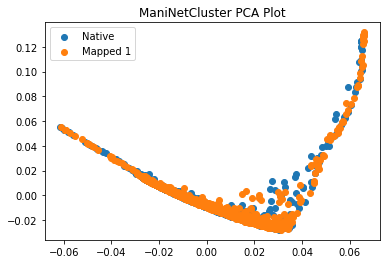

In [13]:
alignment_visualize(*mapping, alg_name='ManiNetCluster')

# MAGAN

In [14]:
import mmd_wrapper.algs.source.magan.train as magan_train_example
xb1, xb2, labels1, labels2 = magan_train_example.get_data()

In [15]:
magan_out = mmd_combine(xb1, xb2,
                        method='magan',
                        max_iterations=10000,
                        verbose=0)
mapping, hist, magan = magan_out

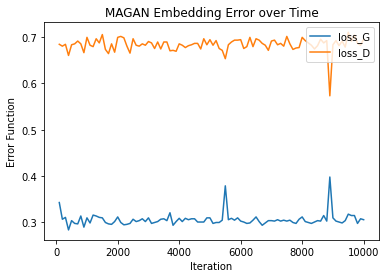

In [16]:
keys = ['loss_G', 'loss_D']
plot_training(hist, keys, alg_name='MAGAN Embedding')

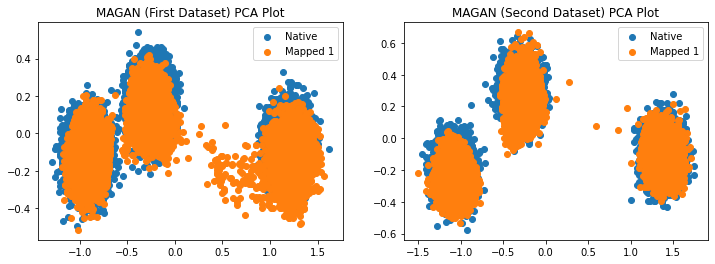

In [17]:
plt.subplots(figsize=(12,4))

plt.subplot(1,2,1)
alignment_visualize(xb1, mapping[0], alg_name='MAGAN (First Dataset)')

plt.subplot(1,2,2)
alignment_visualize(xb2, mapping[1], alg_name='MAGAN (Second Dataset)')

# Comparison

In [18]:
# Read motor data
expression_data = pd.read_csv('./sample_data/scMNC/geneExp_filtered.csv', index_col=0).dropna().transpose()
feature_data = pd.read_csv('./sample_data/scMNC/efeature_filtered.csv').dropna()

data1 = expression_data.to_numpy()
data2 = feature_data.to_numpy()

# Optionally cut for local computation time
if False:
    samples, cols = 200, 10
    data1 = data1[:samples, :cols]
    data2 = data2[:samples, :cols]

In [19]:
# MMD-MA
mmd_ma_out = mmd_combine(data1, data2, method='mmd_ma', similarity_matrices=False)
print('MMD-MA Pairwise Error: ' + str(pairwise_error(*mmd_ma_out[0], normalize_by_feature=True)))
print('MMD-MA Final Loss: ' + str(mmd_ma_out[1]['loss'][-1]))
print()

# Unioncom
unioncom_out = mmd_combine(data1, data2, method='unioncom', verbose=0)
print('UnionCom Pairwise Error: ' + str(pairwise_error(*unioncom_out[0], normalize_by_feature=True)))
print()

# ManiNetCluster
maninet_algo = 'nonlinear manifold aln'
maninetcluster_out = mmd_combine(data1, data2,
                                 method='maninetcluster',
                                 alignment=maninet_algo,
                                 num_dims=2)
print('ManiNetCluster Pairwise Error: ' + str(pairwise_error(*maninetcluster_out[0], normalize_by_feature=True)))
print()

# MAGAN
magan_out = mmd_combine(data1, data2, method='magan', max_iterations=10000, verbose=0)
print('MAGAN (First Set) Pairwise Error: ' + str(pairwise_error(data1, magan_out[0][0], normalize_by_feature=True)))
print('MAGAN (Second Set) Pairwise Error: ' + str(pairwise_error(data2, magan_out[0][1], normalize_by_feature=True)))
print('MAGAN Generator Error: ' + str(magan_out[1]['loss_G'][-1]))
print('MAGAN Discriminator Error: ' + str(magan_out[1]['loss_D'][-1]))

MMD-MA Pairwise Error: 360.6902292603627
MMD-MA Final Loss: 179.458

UnionCom Pairwise Error: 58.166887037456036

ManiNetCluster Pairwise Error: 36.106435323030865

MAGAN (First Set) Pairwise Error: 0.16228590986007108
MAGAN (Second Set) Pairwise Error: 5.572005227758097
MAGAN Generator Error: 17374.852
MAGAN Discriminator Error: 0.003


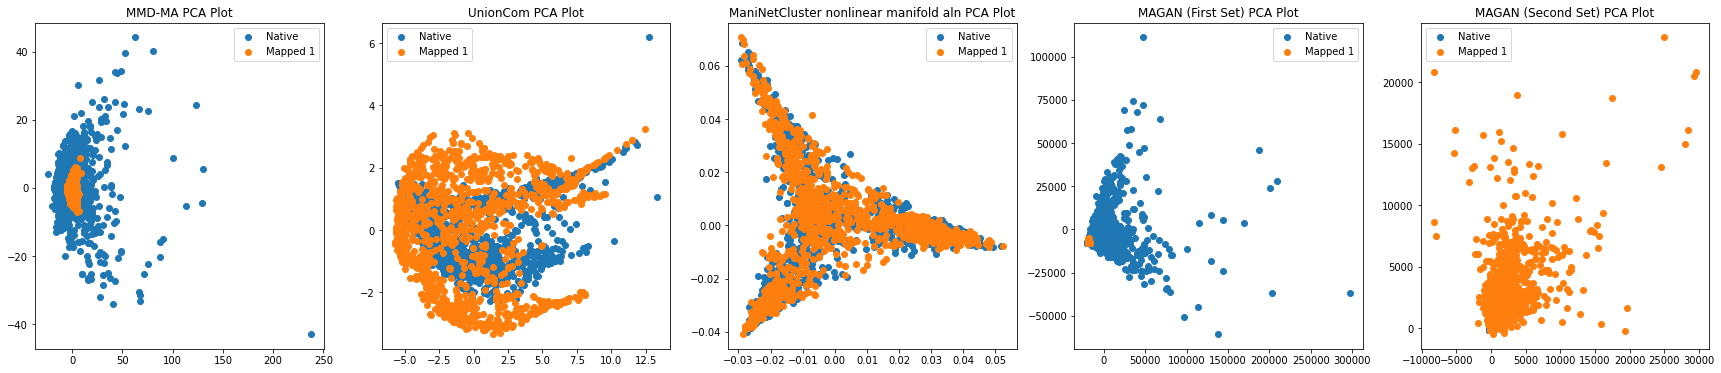

In [20]:
mappings = [mmd_ma_out[0], unioncom_out[0], maninetcluster_out[0], [data1, magan_out[0][0]], [data2, magan_out[0][1]]]
names = ['MMD-MA', 'UnionCom', 'ManiNetCluster ' + maninet_algo, 'MAGAN (First Set)', 'MAGAN (Second Set)']

plt.subplots(figsize=(6*len(names), 6))
for i, mapping in enumerate(mappings):
    plt.subplot(1, len(names), i+1)
    alignment_visualize(*mapping, alg_name=names[i])

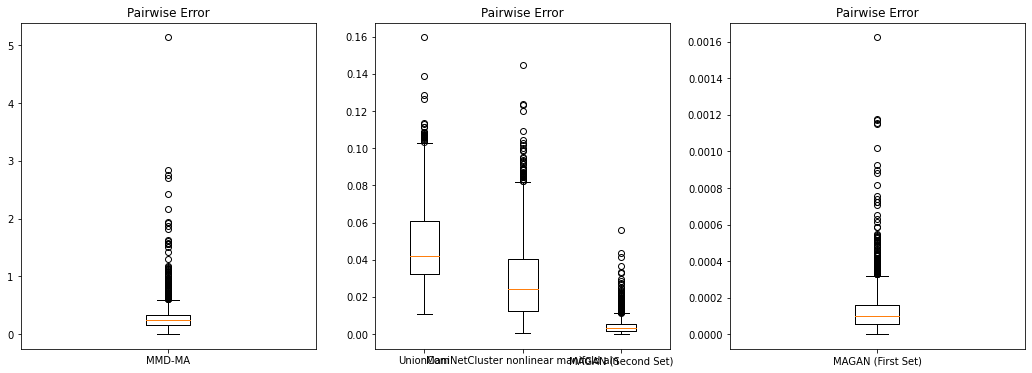

In [21]:
plt.subplots(figsize=(18, 6))
plt.subplot(1, 3, 1)
boxplot(*mmd_ma_out[0], labels=names[0:1], normalize_by_feature=True)
plt.subplot(1, 3, 2)
boxplot(*unioncom_out[0], *maninetcluster_out[0], *[data2, magan_out[0][1]], labels=names[1:3]+names[4:5], normalize_by_feature=True)
plt.subplot(1, 3, 3)
boxplot(*[data1, magan_out[0][0]],  labels=names[3:4], normalize_by_feature=True)

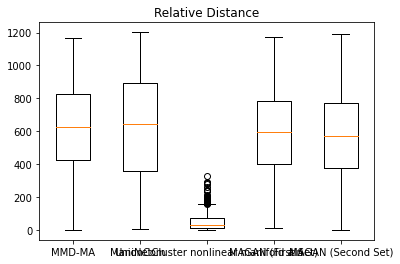

In [22]:
boxplot(*mmd_ma_out[0], *unioncom_out[0], *maninetcluster_out[0], *[data1, magan_out[0][0]], *[data2, magan_out[0][1]],
        boxplot_metric='relative_distance',
        labels=names)